In [57]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from scipy import signal
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

In [58]:
# Load our dataset 
df=pd.read_csv('test.csv')

In [59]:
# Quick check for data regularity, i.e. constant spacing in timestamp data points

# Converting 'Timestamp' column to datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Calculate the time differences between consecutive timestamps
time_diffs = df['Timestamp'].diff().dt.total_seconds()

# Check for irregular sampling by examining the distribution of time differences
print("Summary statistics of time differences:")
print(time_diffs.describe())

# Check for missing data by counting the number of NaN values in the time differences
missing_data_count = time_diffs.isna().sum()
print("\nNumber of missing data points:", missing_data_count)
# The missing data point is simply the result of differencing, i.e. the first timestamp difference will be absent

Summary statistics of time differences:
count    1.814400e+07
mean     1.000000e-01
std      2.981118e-11
min      1.000000e-01
25%      1.000000e-01
50%      1.000000e-01
75%      1.000000e-01
max      1.000000e-01
Name: Timestamp, dtype: float64

Number of missing data points: 1


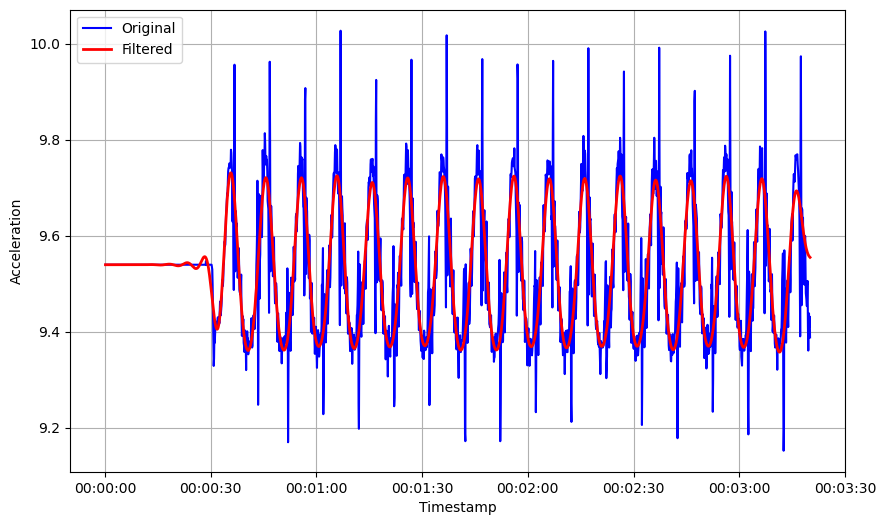

In [62]:
# Test the performance of the Butterworth filter on smoothing the acceleration data
order = 8         # Filter order
cutoff_frequency = 0.04 # Cutoff frequency
b, a = signal.butter(order, cutoff_frequency, output='ba')

start_index = 13824000  # Start index of the range
end_index = 13826000  # End index of the range
filtered_acceleration = signal.filtfilt(b, a, df['Acceleration'].iloc[start_index:end_index])

# Plot original and filtered acceleration
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'].iloc[start_index:end_index], df['Acceleration'].iloc[start_index:end_index], 'b-', label='Original')
plt.plot(df['Timestamp'].iloc[start_index:end_index], filtered_acceleration, 'r-', linewidth=2, label='Filtered')
plt.xlabel("Timestamp")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# Define the band-pass filter parameters 
low_cutoff = 0.01  # Lower cutoff frequency in Hz
high_cutoff = 0.041  # Upper cutoff frequency in Hz
order = 8           # Filter order
# Design the Butterworth band-pass filter
b, a = signal.butter(order, [low_cutoff, high_cutoff], btype='bandpass', analog=False)
# Apply the filter to the filtered_acceleration data
filtered_bandpass_acceleration = signal.filtfilt(b, a, filtered_acceleration)

# Convert Timestamps to seconds
time_seconds = (df['Timestamp'].iloc[start_index:end_index] - df['Timestamp'].iloc[0]).dt.total_seconds()

In [64]:
timestamp_array = df['Timestamp'].iloc[start_index:end_index].values

# Extract hour:minute:second:nanosecond component for all entries
times = []
for timestamp in timestamp_array:
    components = str(timestamp).split('T')
    if len(components) > 1:
        times.append(components[1])
    else:
        times.append(components[0])

times = np.array(times)

# Initialize an empty list to store the time in seconds
time_in_seconds = []

# Iterate over each timestamp in times
for timestamp in times:
    # Split the timestamp into its components
    components = timestamp.split(':')
    # Convert each component to seconds and sum them up
    total_seconds = int(components[0]) * 3600 + int(components[1]) * 60 + float(components[2])
    # Append the total seconds to the time_in_seconds list
    time_in_seconds.append(total_seconds)

# Convert the list to a NumPy array
time_in_seconds = np.array(time_in_seconds)

Active Regions:
Active Region #1: Start Time = 0, Stop Time = 9125
Active Region #2: Start Time = 72064, Stop Time = 81096
Active Region #3: Start Time = 144066, Stop Time = 153099
Active Region #4: Start Time = 216066, Stop Time = 225090
Active Region #5: Start Time = 288066, Stop Time = 297098
Active Region #6: Start Time = 360066, Stop Time = 369095
Active Region #7: Start Time = 432065, Stop Time = 441094
Active Region #8: Start Time = 504065, Stop Time = 513094
Active Region #9: Start Time = 576065, Stop Time = 585059
Active Region #10: Start Time = 648029, Stop Time = 657059
Active Region #11: Start Time = 720029, Stop Time = 729059
Active Region #12: Start Time = 792029, Stop Time = 801063
Active Region #13: Start Time = 864030, Stop Time = 873119
Active Region #14: Start Time = 936066, Stop Time = 945107

Inactive Regions:
Inactive Region #1: Start Time = 9126, Stop Time = 72063
Inactive Region #2: Start Time = 81097, Stop Time = 144065
Inactive Region #3: Start Time = 153100, 

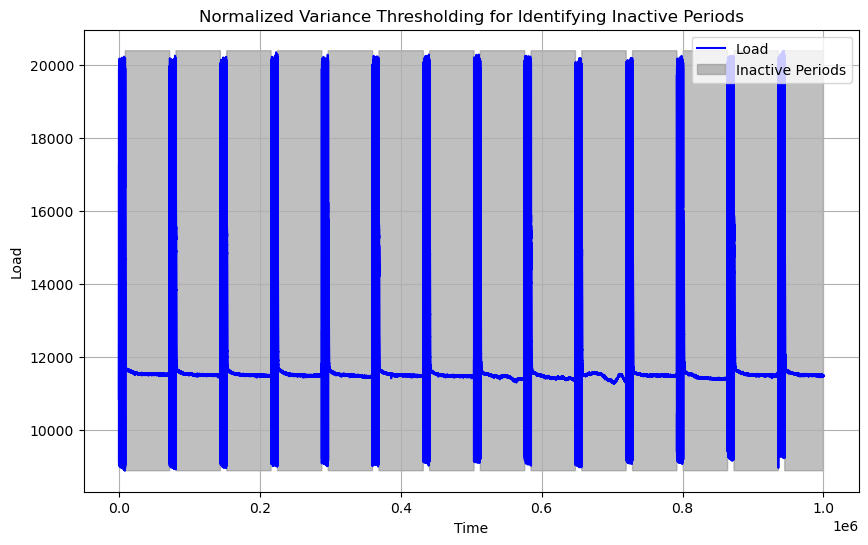

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Select the first n data points of the 'Load' variable
length = 1000000
load_data = df['Load'].iloc[:length]

# Calculate variance using a sliding window approach
window_size = 100  # Adjust as needed
variance_values = load_data.rolling(window=window_size).var()

# Normalize the variance values so that the largest value is equal to 1
normalized_variance = variance_values / np.max(variance_values)

# Define threshold for identifying inactive periods
threshold = 0.1  # Adjust as needed

# Identify inactive periods based on variance threshold
inactive_periods = normalized_variance < threshold

# Identify active and inactive regions
active_regions = []
inactive_regions = []
current_region_start = None

# Function to append region to the appropriate list
def append_region(region_start, region_end, is_inactive):
    if is_inactive:
        inactive_regions.append((region_start, region_end))
    else:
        active_regions.append((region_start, region_end))

# Iterate through the inactive_periods array to identify regions
for i, is_inactive in enumerate(inactive_periods):
    if is_inactive and current_region_start is None:
        current_region_start = i
    elif not is_inactive and current_region_start is not None:
        append_region(current_region_start, i - 1, True)
        current_region_start = None

if current_region_start is not None:
    append_region(current_region_start, len(inactive_periods) - 1, True)

# Identify active regions by finding stretches of False values
current_region_start = None
for i, is_inactive in enumerate(inactive_periods):
    if not is_inactive and current_region_start is None:
        current_region_start = i
    elif is_inactive and current_region_start is not None:
        append_region(current_region_start, i - 1, False)
        current_region_start = None

if current_region_start is not None:
    append_region(current_region_start, len(inactive_periods) - 1, False)

# Output the starting and stopping timestamps for each region
print("Active Regions:")
for idx, (start, stop) in enumerate(active_regions):
    print(f"Active Region #{idx + 1}: Start Time = {load_data.index[start]}, Stop Time = {load_data.index[stop]}")

print("\nInactive Regions:")
for idx, (start, stop) in enumerate(inactive_regions):
    print(f"Inactive Region #{idx + 1}: Start Time = {load_data.index[start]}, Stop Time = {load_data.index[stop]}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(load_data, color='blue', label='Load')
# plt.plot(normalized_variance, color='red', linestyle='--', label='Normalized Variance')
plt.fill_between(load_data.index, np.min(load_data), np.max(load_data), where=inactive_periods, color='gray', alpha=0.5, label='Inactive Periods')
plt.title('Normalized Variance Thresholding for Identifying Inactive Periods')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
buff = 0.05

def smooth_active_accel(region_number):
    if region_number <= len(active_regions):
        start_index, end_index = active_regions[region_number - 1]
        region_length = end_index - start_index
        buffer = int(buff * region_length)  # buffer
        buffered_start_index = start_index + buffer
        buffered_end_index = end_index - buffer

        # Design the Butterworth filter for low-pass filtering
        order = 8                # Filter order
        cutoff_frequency = 0.04  # Cutoff frequency
        b_low, a_low = signal.butter(order, cutoff_frequency, output='ba')

        # Apply the low-pass filter to 'Acceleration' data
        filtered_acceleration = signal.filtfilt(b_low, a_low, df['Acceleration'].iloc[buffered_start_index:buffered_end_index])

        # Define the band-pass filter parameters
        low_cutoff = 0.01  # Lower cutoff frequency in Hz
        high_cutoff = 0.04  # Upper cutoff frequency in Hz
        order = 2           # Filter order

        # Design the Butterworth band-pass filter
        b_bandpass, a_bandpass = signal.butter(order, [low_cutoff, high_cutoff], btype='bandpass', analog=False)

        # Apply the band-pass filter to the filtered acceleration data
        filtered_data_bandpass = signal.filtfilt(b_bandpass, a_bandpass, filtered_acceleration)
        
        return filtered_data_bandpass
    else:
        print(f"Region #{region_number} does not exist.")

In [66]:
# Function to plot the specified region

def plot_region(is_active, region_number):
    regions = active_regions if is_active else inactive_regions
    print(regions[0])
    if region_number <= len(regions):
        region_start, region_end = regions[region_number - 1]
        region_length = region_end - region_start
        buffer = int(buff * region_length)  # 5% buffer
        buffered_region_start = region_start + buffer
        buffered_region_end = region_end - buffer
        plt.figure(figsize=(10, 6))
        plt.plot(load_data[load_data.index[buffered_region_start]:load_data.index[buffered_region_end]], color='blue', label='Load')
        region_type = "Active" if is_active else "Inactive"
        plt.title(f'{region_type} Region #{region_number} Plot')
        plt.xlabel('Time')
        plt.ylabel('Load')
        plt.grid(True)
        plt.show()
    else:
        print(f"Region #{region_number} does not exist.")

In [67]:
from scipy import integrate, signal
import numpy as np

def accel_to_vel(region_number):
    if region_number <= len(active_regions):
        # Smooth the acceleration data for the specified active region
        filtered_data_bandpass = smooth_active_accel(region_number)
        
        # Calculate time array with increments of 0.1 seconds
        time_in_seconds = np.arange(0, len(filtered_data_bandpass) * 0.1, 0.1)
        
        # If lengths are off by 1 or -1, remove one data point from the larger array
        if abs(len(time_in_seconds) - len(filtered_data_bandpass)) == 1:
            if len(time_in_seconds) > len(filtered_data_bandpass):
                time_in_seconds = time_in_seconds[:-1]
            else:
                filtered_data_bandpass = filtered_data_bandpass[:-1]
        
        # Perform numerical integration to calculate velocity
        vel = integrate.cumtrapz(filtered_data_bandpass, x=time_in_seconds, initial=0)
    
        
        # Apply high-pass filter to the velocity
        order_hp = 3           
        cutoff_frequency_hp = 0.013
        b_hp, a_hp = signal.butter(order_hp, cutoff_frequency_hp, btype='high', analog=False)
        hp_vel = signal.filtfilt(b_hp, a_hp, vel)
        
        return hp_vel
    else:
        print(f"Region #{region_number} does not exist.")

In [68]:
def vel_to_pos(region_number):
    if region_number <= len(active_regions):
        hp_vel = accel_to_vel(region_number)
        # Calculate time array with increments of 0.1 seconds
        time_in_seconds = np.arange(0, len(hp_vel) * 0.1, 0.1)
        
        # If lengths are off by 1 or -1, remove one data point from the larger array
        if abs(len(time_in_seconds) - len(hp_vel)) == 1:
            if len(time_in_seconds) > len(hp_vel):
                time_in_seconds = time_in_seconds[:-1]
            else:
                hp_vel = hp_vel[:-1]
                
        # Perform numerical integration to calculate position
        pos = integrate.cumtrapz(hp_vel, x=time_in_seconds, initial=0.1)
        
        return pos
    else:
        print(f"Region #{region_number} does not exist.")
        return None

In [69]:
def plot_load_vs_position(region_number):
    if region_number <= len(active_regions):
        start_index, end_index = active_regions[region_number - 1]
        region_length = end_index - start_index
        buffer = int(buff * region_length)  # 5% buffer
        buffered_start_index = start_index + buffer
        buffered_end_index = end_index - buffer
        
        # Obtain positions
        positions = vel_to_pos(region_number)
        
        # Extract Load values
        loads = df["Load"].iloc[buffered_start_index:buffered_end_index].values
        
        drop_number = 1
        positions = positions[drop_number:-drop_number]
        loads = loads[drop_number:-drop_number]

        # Create scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(positions, loads, color='blue', alpha=0.5, s=2)
        plt.xlabel("Position")
        plt.ylabel("Load")
        plt.title("Load vs. Position")
        plt.title(f"Load vs. Position for Active Region #{region_number}")
        plt.grid(True)
        plt.show()
    else:
        print(f"Region #{region_number} does not exist.")

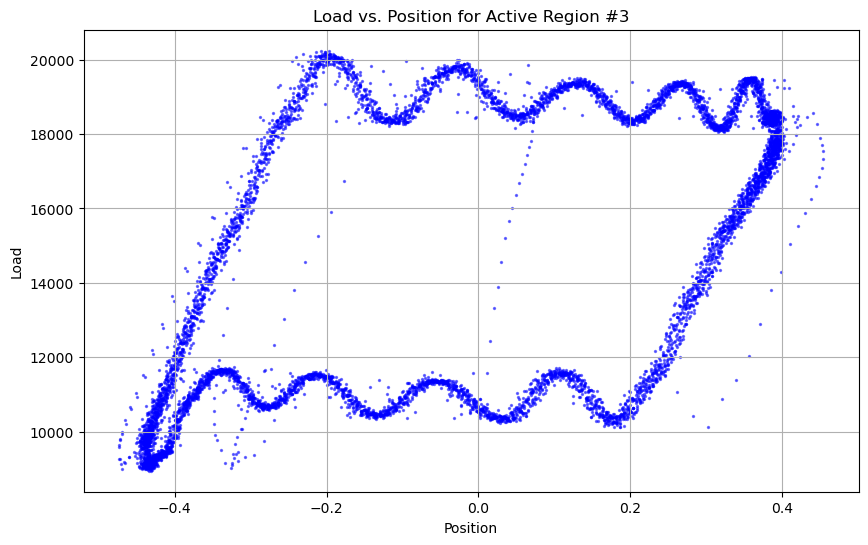

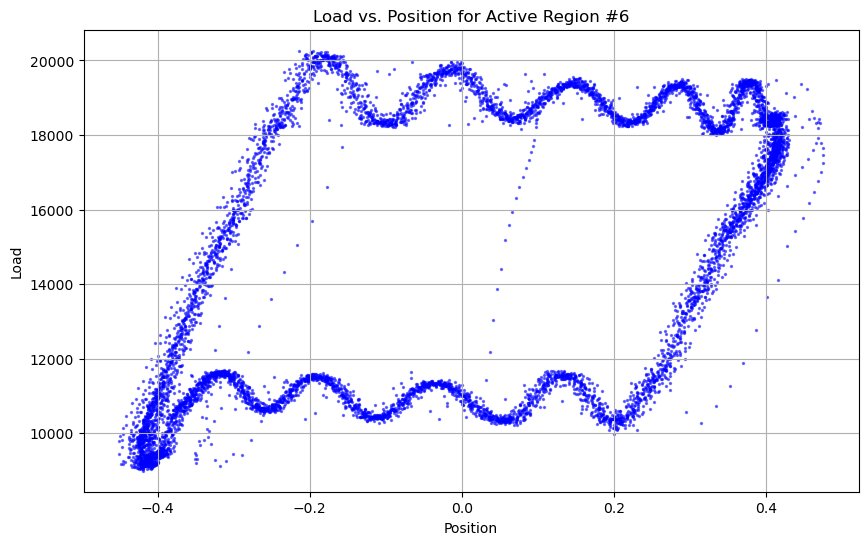

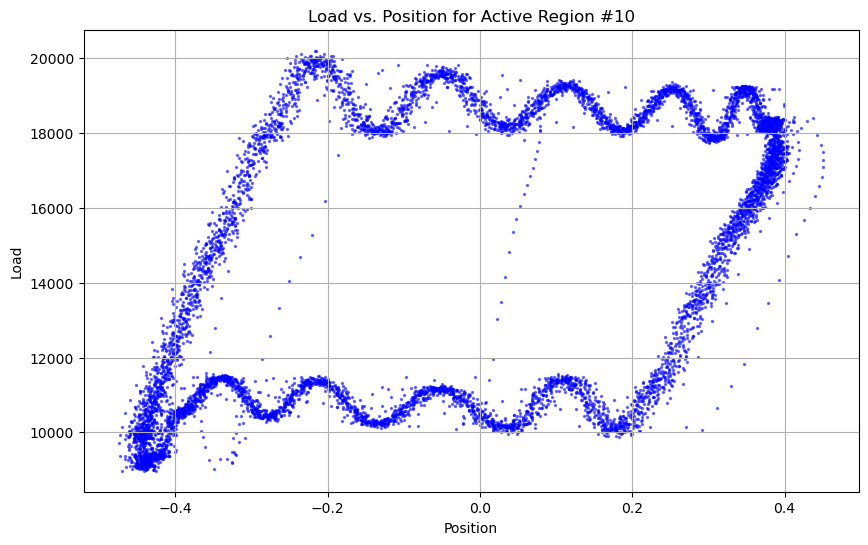

In [70]:
plot_load_vs_position(3)
plot_load_vs_position(6)
plot_load_vs_position(10)